In [1]:
import logging
import time

import awkward as ak
import cabinetry
import cloudpickle
import correctionlib
from coffea import processor
from coffea.nanoevents import NanoAODSchema
from coffea.analysis_tools import PackedSelection
import copy
import hist
import matplotlib.pyplot as plt
import numpy as np
import pyhf

import mplhep as hep
hep.style.use(hep.style.ATLAS)

import utils 

logging.getLogger("cabinetry").setLevel(logging.INFO)

In [2]:
N_FILES_MAX_PER_SAMPLE = 1
USE_DASK=False
USE_SERVICEX=False
USE_SAVED_FEATURES=False

In [3]:
fileset = utils.file_input.construct_fileset(
    N_FILES_MAX_PER_SAMPLE,
    use_xcache=False,
    af_name="coffea_casa",  
    input_from_eos=False,
    xcache_atlas_prefix=None,
)

print(f"processes in fileset: {list(fileset.keys())}")
print(f"\nexample of information in fileset:\n{{\n  'files': [{fileset['ttbar__nominal']['files'][0]}, ...],")
print(f"  'metadata': {fileset['ttbar__scaleup']['metadata']}\n}}")

processes in fileset: ['ttbar__nominal', 'ttbar__scaledown', 'ttbar__scaleup', 'ttbar__ME_var', 'ttbar__PS_var', 'single_top_s_chan__nominal', 'single_top_t_chan__nominal', 'single_top_tW__nominal', 'wjets__nominal']

example of information in fileset:
{
  'files': [https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0000.root, ...],
  'metadata': {'process': 'ttbar', 'variation': 'scaleup', 'nevts': 1278695, 'xsec': 729.84}
}


In [4]:
NanoAODSchema.warn_missing_crossrefs = False # silences warnings about branches we will not use here

executor = processor.FuturesExecutor(workers=4)

run = processor.Runner(
    executor=executor,
    schema=NanoAODSchema,
    savemetrics=True,
    metadata_cache={},
    chunksize=200000)

treename = "Events"


filemeta = run.preprocess(fileset, treename=treename)  # pre-processing



Output()

In [5]:
# labels_dict = {"ttbar": 0,
#                "single_top_s_chan":1,
#               "single_top_t_chan":2,
#               "single_top_tW":3,
#               "wjets":4}

# Keep only a subset of the background for illustration
labels_dict = {"ttbar": 0,
              "single_top_t_chan":1,
              "wjets":2}

In [11]:
# function to create column accumulator from list
def col_accumulator(a):
    return processor.column_accumulator(np.array(a))

processor_base = processor.ProcessorABC
class NSBI_analysis(processor_base):
    def __init__(self):
        super().__init__()
    
    def process(self, events):
        
        # Note: This creates new objects, distinct from those in the 'events' object
        elecs = events.Electron
        muons = events.Muon
        jets = events.Jet
        
        process = events.metadata["process"]  # "ttbar" etc.
        
        if process in ["single_top_s_chan", "single_top_tW"]: 
            return {}
        
        variation = events.metadata["variation"]  # "nominal" etc.
        
        # normalization for MC
        x_sec = events.metadata["xsec"]
        nevts_total = events.metadata["nevts"]
        lumi = 3378 # /pb

        if process != "data":
            xsec_weight = x_sec * lumi / nevts_total
        else:
            xsec_weight = 1

        electron_reqs = (elecs.pt > 10) & (np.abs(elecs.eta) < 2.4) & (elecs.pt < 500)
        muon_reqs = ((muons.pt > 10) & (np.abs(muons.eta) < 2.4)) & (muons.pt < 500)
        # jet_reqs = (jets.pt > 30) & (np.abs(jets.eta) < 2.4) & (jets.isTightLeptonVeto)
        jet_reqs = (jets.pt > 15) & (np.abs(jets.eta) < 2.4)

        # Only keep objects that pass our requirements
        elecs = elecs[electron_reqs]
        muons = muons[muon_reqs]
        jets = jets[jet_reqs]

        B_TAG_THRESHOLD = 0.5

        ######### Store boolean masks with PackedSelection ##########
        selections = PackedSelection(dtype='uint64')
        # Basic selection criteria
        selections.add("exactly_1l", (ak.num(elecs) + ak.num(muons)) == 1)
        selections.add("atleast_4j", ak.num(jets) >= 4)
        selections.add("atleast_1bj", ak.sum(jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 1)

        selections.add("Inclusive", selections.all("exactly_1l"))
        # selections.add("Inclusive", selections.all("exactly_1l", "atleast_4j"))
        # selections.add("Inclusive", selections.all("exactly_1l", "atleast_4j", "atleast_1bj"))

        selection = selections.all("Inclusive")
        selected_jets = jets[selection]
        selected_elecs = elecs[selection]
        selected_muons = muons[selection]
        selected_weights = np.ones(len(selected_jets)) * xsec_weight


        # # calculate number of jets in each event
        # njet = ak.num(selected_jets).to_numpy()

        # grab lepton info
        leptons = ak.flatten(ak.concatenate((selected_elecs, selected_muons), axis=1), axis=-1)

        # H_T = ak.sum(selected_jets.pt, axis=-1)
        pT_lep = leptons.pt
        eta_lep = leptons.eta
        phi_lep = leptons.phi
        
        #### calculate features ####
        features = np.zeros((len(pT_lep), 3))
        
        features[:, 0] = pT_lep
        features[:, 1] = eta_lep
        features[:, 2] = phi_lep

        
#         # pt of every jet
#         features[:, 2] = ak.Array(selected_jets[:,0].pt).to_numpy()
#         features[:, 3] = ak.Array(selected_jets[:,1].pt).to_numpy()
#         features[:, 4] = ak.Array(selected_jets[:,2].pt).to_numpy()
#         features[:, 5] = ak.Array(selected_jets[:,3].pt).to_numpy()

#         # btagCSVV2 of every jet
#         features[:, 6] = ak.Array(selected_jets[:,0].btagCSVV2).to_numpy()
#         features[:, 7] = ak.Array(selected_jets[:,1].btagCSVV2).to_numpy()
#         features[:, 8] = ak.Array(selected_jets[:,2].btagCSVV2).to_numpy()
#         features[:, 9] = ak.Array(selected_jets[:,3].btagCSVV2).to_numpy()

#         # quark-gluon likelihood discriminator of every jet
#         features[:, 10] = ak.Array(selected_jets[:,0].qgl).to_numpy()
#         features[:, 11] = ak.Array(selected_jets[:,1].qgl).to_numpy()
#         features[:, 12] = ak.Array(selected_jets[:,2].qgl).to_numpy()
#         features[:, 13] = ak.Array(selected_jets[:,3].qgl).to_numpy()


        train_labels = np.full_like(pT_lep, labels_dict[process])


        output = {"train_labels": col_accumulator(train_labels.tolist()),
                  "weights": col_accumulator(selected_weights.tolist()),
                  "features": col_accumulator(features.tolist())}


        return output
        
    def postprocess(self, accumulator):
        return accumulator

In [12]:
if not USE_SAVED_FEATURES:
    
    t0 = time.monotonic()
    # processing
    output, metrics = run(
        fileset,
        treename,
        processor_instance=NSBI_analysis()
    )


    exec_time = time.monotonic() - t0


    print(f"\nexecution took {exec_time:.2f} seconds")

Output()


execution took 74.19 seconds


In [13]:
saved_data = "./cached_data/"

In [14]:
if USE_SAVED_FEATURES:
    
    features = np.load(f"{saved_data}features.npy")
    train_labels = np.load(f"{saved_data}train_labels.npy")
    weights = np.load(f"{saved_data}weights.npy")
    
else:

    # grab features and labels and convert to np array
    features = np.array(output['features'].value)
    train_labels = np.array(output['train_labels'].value)
    weights = np.array(output['weights'].value)
    
    np.save(f"{saved_data}features.npy", features)
    np.save(f"{saved_data}train_labels.npy", train_labels - 1)        
    np.save(f"{saved_data}weights.npy", weights)        

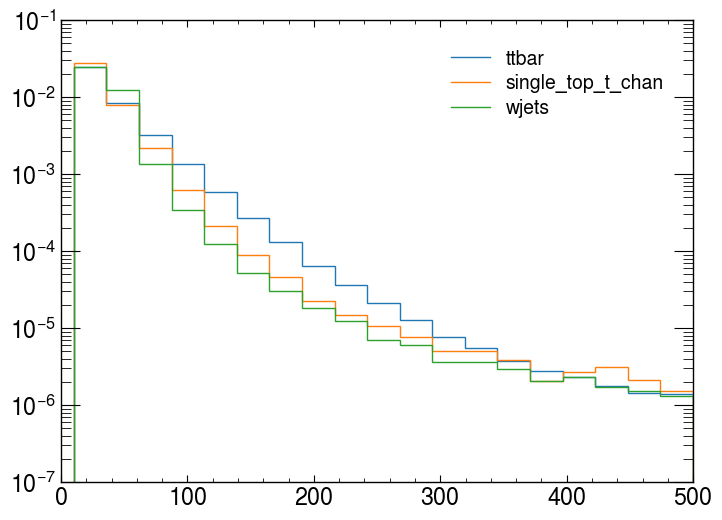

In [15]:
bins=np.linspace(10.0, 500.0, num=20)
hist_lep_pt = {}

for key in labels_dict:
    
    hist_lep_pt[key], _ = np.histogram(features[:,0][train_labels==labels_dict[key]], weights = weights[train_labels==labels_dict[key]], bins=bins)

for key in labels_dict:

    hep.histplot(hist_lep_pt[key], bins=bins, label=key, density=1)

plt.yscale('log')
plt.legend(loc='upper right')

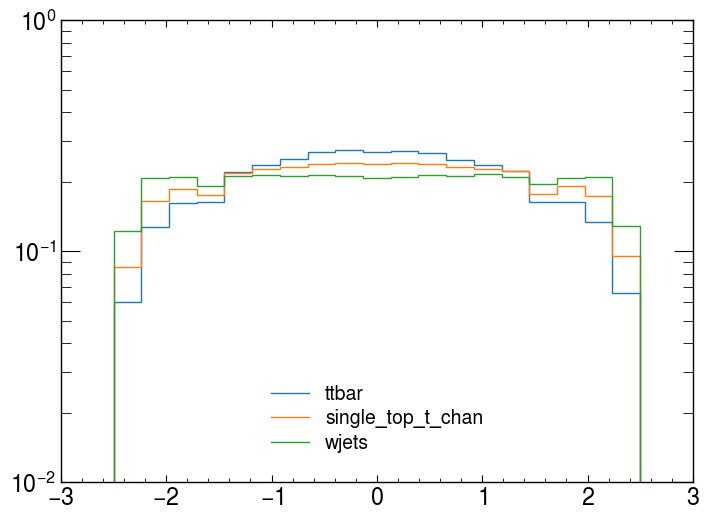

In [16]:
bins=np.linspace(-2.5, 2.5, num=20)
hist_lep_eta = {}

for key in labels_dict:
    
    hist_lep_eta[key], _ = np.histogram(features[:,1][train_labels==labels_dict[key]], weights = weights[train_labels==labels_dict[key]], bins=bins)

for key in labels_dict:

    hep.histplot(hist_lep_eta[key], bins=bins, label=key, density=1)

plt.yscale('log')
plt.legend(loc='lower center')

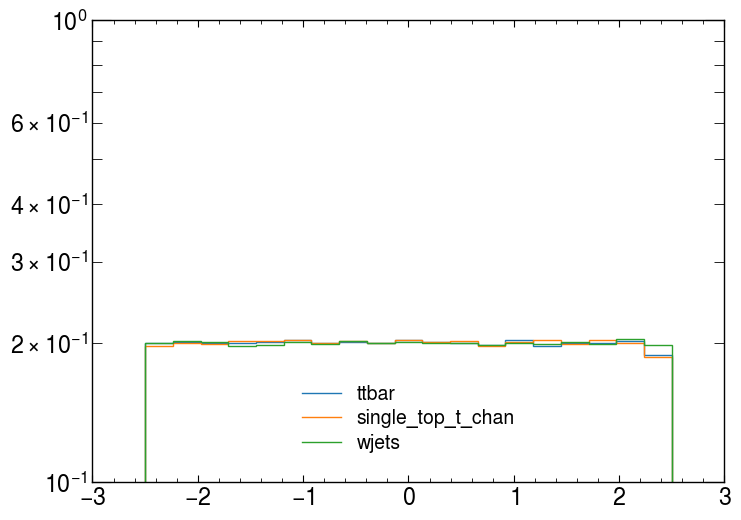

In [17]:
bins=np.linspace(-2.5, 2.5, num=20)
hist_lep_phi = {}

for key in labels_dict:
    
    hist_lep_phi[key], _ = np.histogram(features[:,2][train_labels==labels_dict[key]], weights = weights[train_labels==labels_dict[key]], bins=bins)

for key in labels_dict:

    hep.histplot(hist_lep_phi[key], bins=bins, label=key, density=1)

plt.yscale('log')
plt.legend(loc='lower center')

Training the Preselection NN
===

Now we train a multi-variate, multi-class classifier just to eliminate phase space with no signal events.

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.optimizers import Nadam


2025-02-08 10:40:00.969578: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-08 10:40:01.008212: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-08 10:40:01.008873: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-08 10:40:01.784381: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [22]:
# # One-hot encode labels
# encoder = OneHotEncoder(sparse_output=False, categories='auto')
# train_labels_reshaped = train_labels.reshape(-1, 1)
# train_labels_onehot = encoder.fit_transform(train_labels_reshaped)

# Standardize the input features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)  # Fit & transform training data

# Split data into training and validation sets (including weights)
X_train, X_val, y_train, y_val, weight_train, weight_val = train_test_split(
    features_scaled, train_labels, weights, test_size=0.25, random_state=42
)


# Define the neural network model
model = keras.Sequential([
    layers.Input(shape=(features.shape[1],)),  # Input layer
    layers.Dense(100, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(5, activation='softmax')  # Output layer for 5 classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

# Train the model with sample weights
model.fit(X_train, y_train, sample_weight=weight_train, 
          validation_data=(X_val, y_val), epochs=5, batch_size=10000)


Epoch 1/5
266/266 [==============================] - 3s 8ms/step - loss: 4.3204 - accuracy: 0.1602 - val_loss: 1.7354 - val_accuracy: 0.1595
Epoch 2/5
266/266 [==============================] - 2s 7ms/step - loss: 3.8154 - accuracy: 0.1569 - val_loss: 1.7600 - val_accuracy: 0.1518
Epoch 3/5
266/266 [==============================] - 2s 7ms/step - loss: 3.8092 - accuracy: 0.1622 - val_loss: 1.7226 - val_accuracy: 0.1636
Epoch 4/5
266/266 [==============================] - 2s 7ms/step - loss: 3.8066 - accuracy: 0.1681 - val_loss: 1.8109 - val_accuracy: 0.1565
Epoch 5/5
266/266 [==============================] - 2s 7ms/step - loss: 3.8055 - accuracy: 0.1704 - val_loss: 1.7211 - val_accuracy: 0.1803


In [54]:
# Get predictions (softmax outputs)
pred_NN = model.predict(features_scaled)

110475/110475 [==============================] - 49s 445us/step


(3535175,)


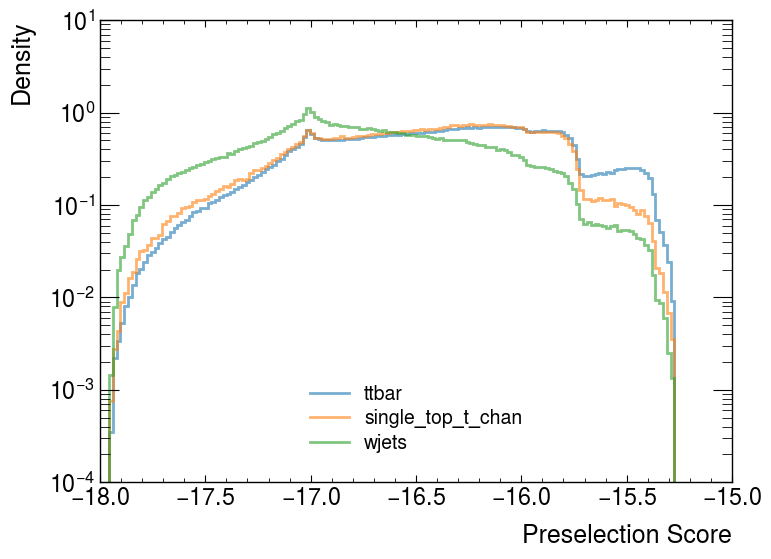

In [55]:

presel_score = np.log(pred_NN[:, labels_dict["ttbar"]]/(np.sum([pred_NN[:, labels_dict[key]] for key in list(labels_dict.keys())[1:]])))

print(presel_score.shape)
min_pred = np.amin(presel_score)
max_pred = np.amax(presel_score)

bins = np.linspace(min_pred, max_pred, num=150)

hist_NN_output = {}
for key in labels_dict: 
    hist_NN_output[key], _ = np.histogram(presel_score[train_labels==labels_dict[key]], weights = weights[train_labels==labels_dict[key]], bins=bins)


for key in labels_dict:  
    hep.histplot(hist_NN_output[key], bins=bins, 
             alpha=0.6, label=key, 
             density=True, linewidth=2.0)

plt.xlabel("Preselection Score", size=18)
plt.ylabel("Density", size=18)
plt.legend()
plt.yscale('log')
plt.show()

In [ ]:
np.save(f'{saved_data}preselection_score.npy', presel_score)

Make a selection cut for performing the NSBI analysis, balancing the number of signal events that go into the signal region (increasing sensitivity) and the feasibility of training accurate and precise NNs over a large phase space (need bigger models and more statistics).

As a first cut, we choose a loose preselection and see if it works.

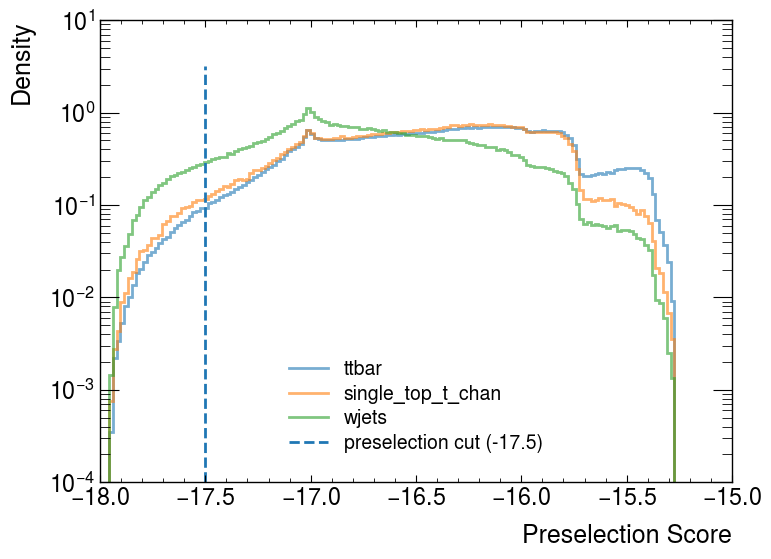

In [64]:
preselection_cut = -17.5 # Lets start with a very loose cut

for key in labels_dict:  
    hep.histplot(hist_NN_output[key], bins=bins, 
             alpha=0.6, label=key, 
             density=True, linewidth=2.0)

plt.xlabel("Preselection Score", size=18)
plt.axvline(preselection_cut, ymax=0.9, linestyle='--', label=f'preselection cut ({preselection_cut})')
plt.ylabel("Density", size=18)
plt.legend()
plt.yscale('log')
plt.show()